---
title: iono
---

## Implémentation de classifieurs binaires 

### Imports

In [1]:
from joblib import parallel_backend
parallel_backend("loky", n_jobs=-1)

In [2]:
import sys
sys.path.append("./../src/")

from get_dataset import dataset_loaders
dataset = list(dataset_loaders.keys())[6]
dataset

'bankmarketing'

In [3]:
# Parameters
dataset = "iono"


In [4]:
from get_dataset import load_dataset

X, y = load_dataset(dataset)

### Data presentation

**{eval}`dataset`\** dataset contains `n` = {eval}`X.shape[0]` samples and `p` = {eval}`X.shape[1]` features.

The target variable is binary and {eval}`y.mean() * 100:.2f`% of the samples are positive.

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

# Normalize data using only the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Prepare model results storage

In [6]:
MODELS = dict()

def store_results(name, grid):
    MODELS[name] = {
        "best_params": grid.best_params_,
        "X_test": X_test,
        "y_true": y_test,
        "y_pred": grid.predict(X_test),
        "y_proba": grid.predict_proba(X_test)
    }
     
    pass

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

def get_grid(model, params):
    # grid = GridSearchCV(model, params, n_jobs=-1, cv=5)
    grid = HalvingRandomSearchCV(model, params, n_jobs=-1, cv=5, verbose=1, scoring="accuracy", refit=True)
    return grid

### Entraînement des classifieurs

#### Classifieurs non paramétriques

##### K-Nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(weights='uniform', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=12. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits


python(15896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


##### Distance-Weighted KNN

In [9]:
model = KNeighborsClassifier(weights='distance', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN Distance Weighted', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=12. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### Condensed Nearest Neighbor

In [10]:
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y
from sklearn.utils.validation import validate_data

# Wrap CondensedNearestNeighbour into an sklearn compatible transformer for use in pipelines
class CondensedNearestNeighbourTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy = "auto", random_state = 42, n_neighbors = None, n_seeds_S = 1):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.n_neighbors = n_neighbors
        self.n_seeds_S = n_seeds_S

    def fit(self, X, y=None):
        # validate_data(X, y, accept_sparse=True, reset=True)
        self.n_features_in_ = X.shape[1]
        
        return self

    def transform(self, X, y=None):
        # check_X_y(X, y)

        if y is None:
            return X
        else:    
          return CondensedNearestNeighbour(
            sampling_strategy = self.sampling_strategy,
            random_state = self.random_state,
            n_neighbors = self.n_neighbors,
            n_seeds_S = self.n_seeds_S
          ).fit_resample(X, y)

from sklearn.utils.estimator_checks import check_estimator
# check_estimator(CondensedNearestNeighbourTransformer())

In [11]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('cnn', CondensedNearestNeighbourTransformer(sampling_strategy='auto', n_neighbors=3, n_seeds_S=1)),
    ('knn', KNeighborsClassifier(weights='uniform', algorithm='auto'))
])

param_grid = {
    'cnn__n_neighbors': [3, 5, 7, 9],
    'knn__n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN Condensed Nearest Neighbor', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### Locally Adaptive KNN

In [12]:
class LocallyAdaptiveKNN(KNeighborsClassifier):
    def predict(self, X):
        distances, indices = self.kneighbors(X)
        predictions = []
        for i, neighbors in enumerate(indices):
            local_k = int(len(neighbors) / 2)  # Example of adapting k locally
            local_knn = KNeighborsClassifier(n_neighbors=local_k)
            local_knn.fit(self._fit_X[neighbors], self._y[neighbors])
            predictions.append(local_knn.predict([X[i]])[0])
        return predictions

model = LocallyAdaptiveKNN(weights='uniform', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN Locally Adaptive', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=12. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


#### Classifieurs binaires non linéaires

##### Arbre de décision (Decision Tree)

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Decision Tree', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### Forêt aléatoire (RandomForest)

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight=None)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Random Forest', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### Forêt aléatoire avec cost-sensitive learning

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Random Forest - cost-sensitive learning', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### AdaBoost

In [16]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('AdaBoost', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 20
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=12. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 180
Fitting 5 folds for each of 1 candidates, totalling 5 fits


##### Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'loss': ['log_loss', 'exponential'],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7, 9]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Gradient Boosting', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


#### Classifieurs binaires paramétriques

##### SVM Linéaire

In [18]:
from sklearn.svm import SVC

model = SVC(
    kernel='linear',
    random_state=42, probability=True)

param_grid = {
    'C': [0.1, 0.5, 1],
    'degree': [2, 3, 4]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 20
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=12. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 180
Fitting 5 folds for each of 1 candidates, totalling 5 fits


##### SVM  non linéaire

In [19]:
from sklearn.svm import SVC

model = SVC(random_state=42, probability=True)

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM non linéaire', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### SVM non linéaire avec sur-échantillonnage

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

# Normalize data using only the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

model = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)),
    ('svm', SVC(random_state=42, probability=True))
])

param_grid = {
    'svm__kernel': ['poly', 'rbf', 'sigmoid'],
    'svm__C': [0.1, 0.5, 1],
    'svm__gamma': ['scale', 'auto']
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM non linéaire avec SMOTE', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### SVM avec cost-sensitive learning (ajustement pénalité C)

In [22]:
from sklearn.svm import SVC

model = SVC(random_state=42, probability=True, class_weight='balanced')

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM cost-sensitive learning', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### Régression logistique

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, solver='liblinear', dual=False)

param_grid = {
    'C': [0.1, 0.5, 1],                         # Inverse de la force de régularisation
    'penalty': ['l1', 'l2'],      # Type de régularisation
    'class_weight': [None, 'balanced']          # Poids des classes
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Logistic Regression', grid_search)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 245
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


#### Sauvegarde des prédictions et paramètres des modèles

In [24]:
from pathlib import Path
from joblib import dump

# Save models results
dump(MODELS, f"./../results/{dataset}.joblib")

['./../results/iono.joblib']

#### Performance des modèles sur les données de test

Model: KNN


,precision,recall,f1-score,support
0,81.48%,98.51%,89.19%,67
1,96.00%,61.54%,75.00%,39
accuracy,,,84.91%,106
macro avg,88.74%,80.02%,82.09%,106
weighted avg,86.82%,84.91%,83.97%,106


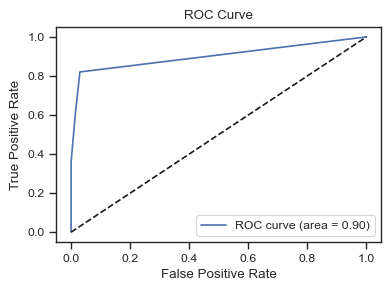

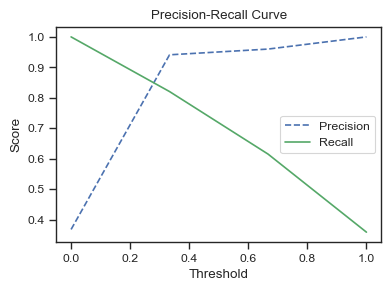

Model: KNN Distance Weighted


,precision,recall,f1-score,support
0,79.76%,100.00%,88.74%,67
1,100.00%,56.41%,72.13%,39
accuracy,,,83.96%,106
macro avg,89.88%,78.21%,80.44%,106
weighted avg,87.21%,83.96%,82.63%,106


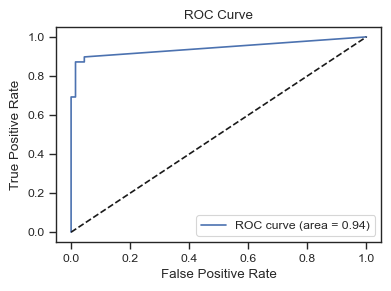

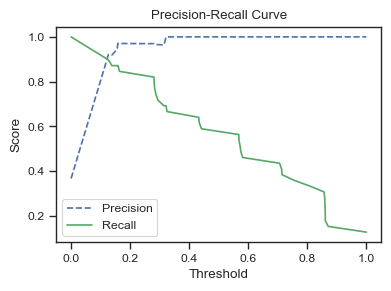

Model: KNN Condensed Nearest Neighbor


,precision,recall,f1-score,support
0,81.48%,98.51%,89.19%,67
1,96.00%,61.54%,75.00%,39
accuracy,,,84.91%,106
macro avg,88.74%,80.02%,82.09%,106
weighted avg,86.82%,84.91%,83.97%,106


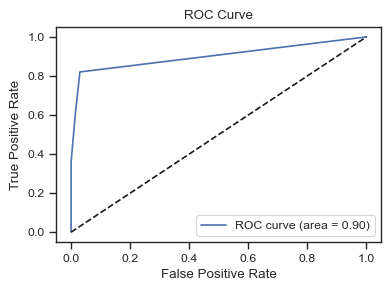

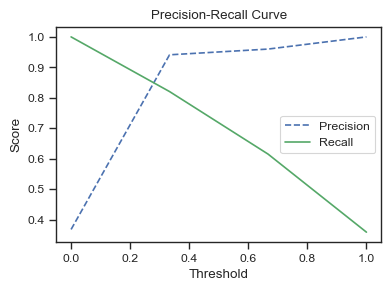

Model: KNN Locally Adaptive


,precision,recall,f1-score,support
0,81.48%,98.51%,89.19%,67
1,96.00%,61.54%,75.00%,39
accuracy,,,84.91%,106
macro avg,88.74%,80.02%,82.09%,106
weighted avg,86.82%,84.91%,83.97%,106


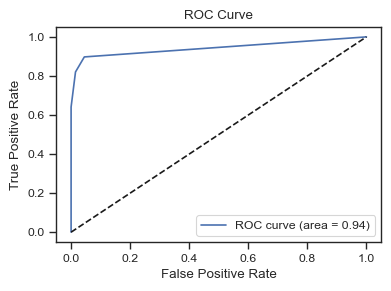

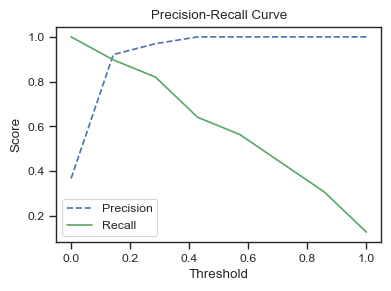

Model: Decision Tree


,precision,recall,f1-score,support
0,88.89%,95.52%,92.09%,67
1,91.18%,79.49%,84.93%,39
accuracy,,,89.62%,106
macro avg,90.03%,87.50%,88.51%,106
weighted avg,89.73%,89.62%,89.45%,106


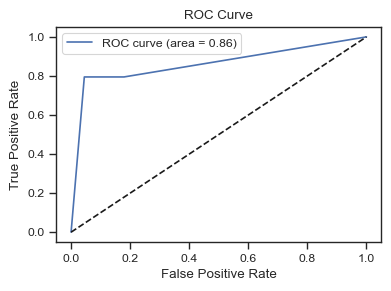

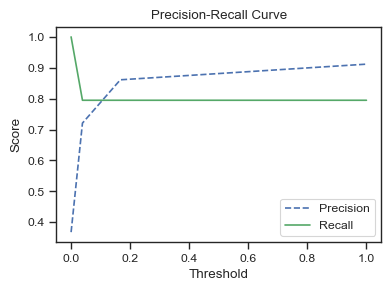

Model: Random Forest


,precision,recall,f1-score,support
0,94.29%,98.51%,96.35%,67
1,97.22%,89.74%,93.33%,39
accuracy,,,95.28%,106
macro avg,95.75%,94.13%,94.84%,106
weighted avg,95.37%,95.28%,95.24%,106


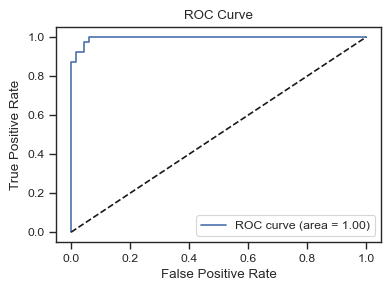

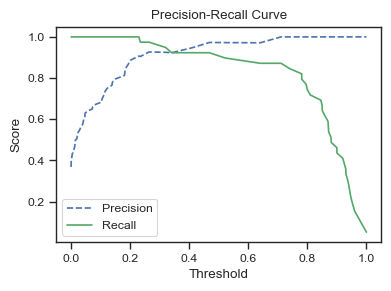

Model: Random Forest - cost-sensitive learning


,precision,recall,f1-score,support
0,92.96%,98.51%,95.65%,67
1,97.14%,87.18%,91.89%,39
accuracy,,,94.34%,106
macro avg,95.05%,92.84%,93.77%,106
weighted avg,94.50%,94.34%,94.27%,106


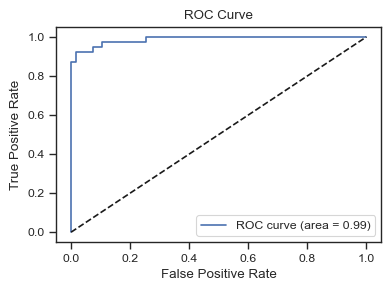

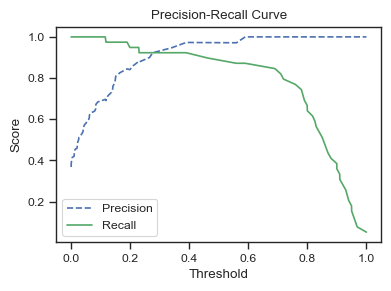

Model: AdaBoost


,precision,recall,f1-score,support
0,91.55%,97.01%,94.20%,67
1,94.29%,84.62%,89.19%,39
accuracy,,,92.45%,106
macro avg,92.92%,90.82%,91.70%,106
weighted avg,92.56%,92.45%,92.36%,106


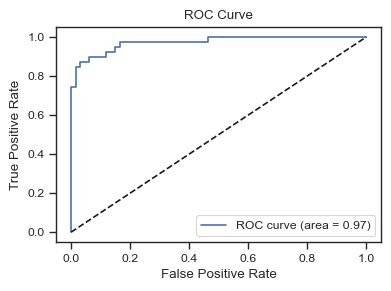

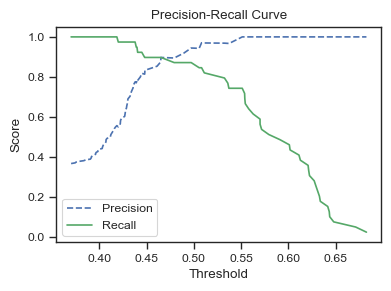

Model: Gradient Boosting


,precision,recall,f1-score,support
0,88.00%,98.51%,92.96%,67
1,96.77%,76.92%,85.71%,39
accuracy,,,90.57%,106
macro avg,92.39%,87.72%,89.34%,106
weighted avg,91.23%,90.57%,90.29%,106


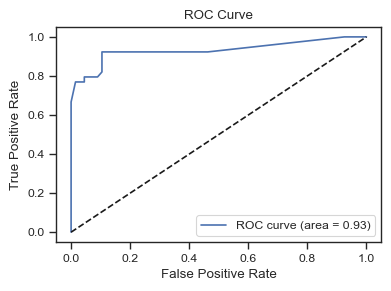

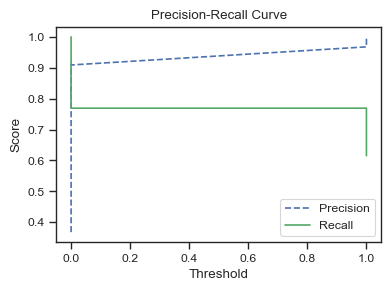

Model: SVM


,precision,recall,f1-score,support
0,84.62%,98.51%,91.03%,67
1,96.43%,69.23%,80.60%,39
accuracy,,,87.74%,106
macro avg,90.52%,83.87%,85.82%,106
weighted avg,88.96%,87.74%,87.19%,106


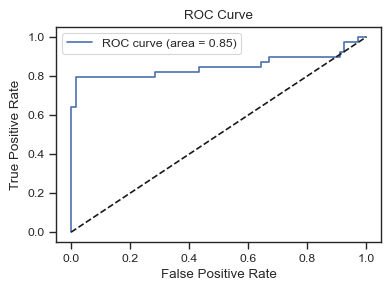

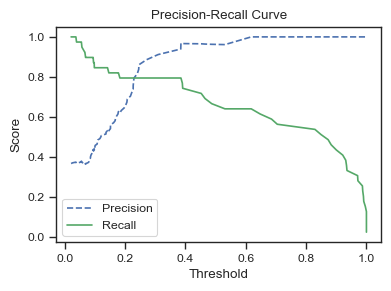

Model: SVM non linéaire


,precision,recall,f1-score,support
0,82.50%,98.51%,89.80%,67
1,96.15%,64.10%,76.92%,39
accuracy,,,85.85%,106
macro avg,89.33%,81.31%,83.36%,106
weighted avg,87.52%,85.85%,85.06%,106


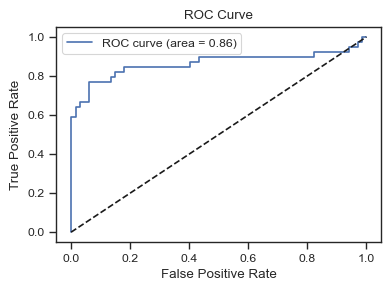

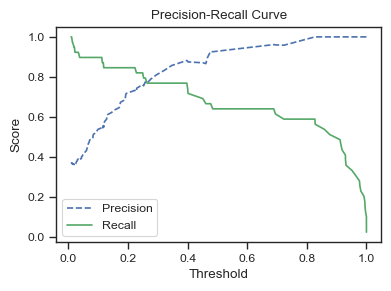

Model: SVM non linéaire avec SMOTE


,precision,recall,f1-score,support
0,97.10%,100.00%,98.53%,67
1,100.00%,94.87%,97.37%,39
accuracy,,,98.11%,106
macro avg,98.55%,97.44%,97.95%,106
weighted avg,98.17%,98.11%,98.10%,106


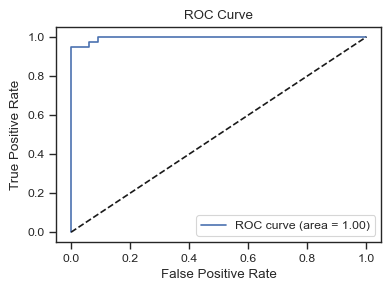

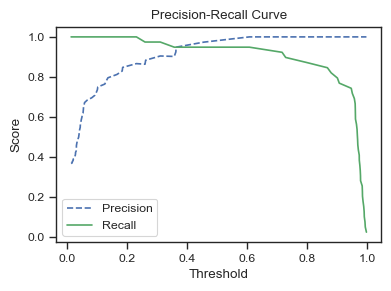

Model: SVM cost-sensitive learning


,precision,recall,f1-score,support
0,95.71%,100.00%,97.81%,67
1,100.00%,92.31%,96.00%,39
accuracy,,,97.17%,106
macro avg,97.86%,96.15%,96.91%,106
weighted avg,97.29%,97.17%,97.14%,106


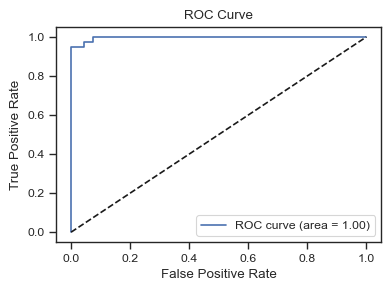

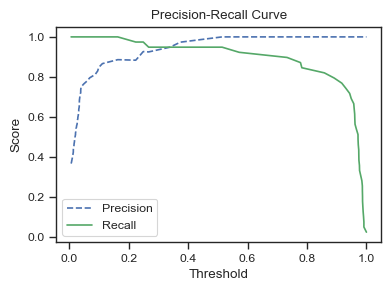

Model: Logistic Regression


,precision,recall,f1-score,support
0,84.62%,98.51%,91.03%,67
1,96.43%,69.23%,80.60%,39
accuracy,,,87.74%,106
macro avg,90.52%,83.87%,85.82%,106
weighted avg,88.96%,87.74%,87.19%,106


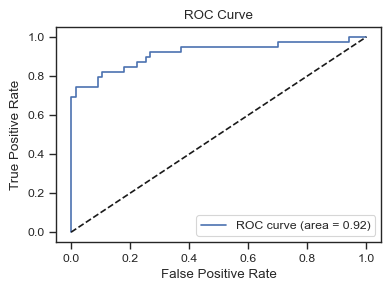

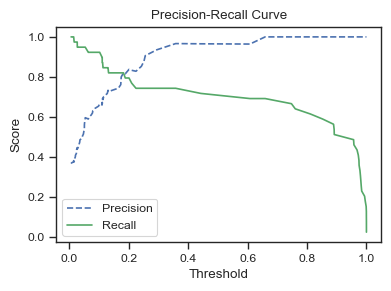

In [25]:
from utils import plot_roc, plot_precision_recall, table_report

for model_name, model in MODELS.items():
    print(f"Model: {model_name}")
    table_report(model['y_true'], model['y_pred'])
    plot_roc(model['y_true'], model['y_proba'][:, 1])
    plot_precision_recall(model['y_true'], model['y_proba'][:, 1])